In [2]:
import json
import math
import yaml
import pandas as pd
import sys
sys.path.append('..')
from pathlib import Path
import filterlist_parser
from importlib import reload
import stats
reload(stats)
import utils
reload(utils)
from gh_scraper.extract import  ublock as ublock_extract
from datetime import datetime, timezone
from matplotlib import pyplot as plt
import numpy as np

CONF_DIR = Path('../conf/').resolve()
DATA_DIR = Path('../data/').resolve()
ISSUES_DIR = Path('../data/issues/').resolve()
# ADGUARD_CONFS_DIR = DATA_DIR / "adguard/2024-02-20/issues_confs.csv"
UBLOCK_CONFS_DIR = ISSUES_DIR / "ublock/2024-06-11/issues_confs.csv"
UBLOCK_DEDUP_CONFS_DIR = ISSUES_DIR / "ublock/2024-06-14:dedup/issues_confs.csv"
ADGUARD_CONFS_DIR = ISSUES_DIR / "adguard/2024-04-24/issues_confs.csv"

reload(utils)
ATTACK_NAMES = utils.get_attack_names(CONF_DIR)


# Rule stability

In [3]:


RULE_LAST_SEEN_DATASETS = {
    "adguard": (datetime(2024, 3, 29, tzinfo=timezone.utc), pd.read_csv(DATA_DIR / "commits/adguard/history/2024-03-29/rules_last_seen.csv")),
    "ublock": (datetime(2024, 4, 24, tzinfo=timezone.utc), pd.read_csv(DATA_DIR / "commits/ublock/history/2024-04-24/rules_last_seen.csv"))
}

In [16]:
df = RULE_LAST_SEEN_DATASETS['ublock'][1].copy()

df_imp = pd.read_csv(DATA_DIR / "commits/ublock/history/2024-04-24/important_rules.csv")
df = df.merge(df_imp, on="rule")
df.last_seen.value_counts().sort_values(ascending=False).head(10)

dd= df.last_seen.value_counts().sort_values(ascending=False).index[7]
print(dd, -( pd.to_datetime(dd, utc=True) - datetime(2024, 4, 24, tzinfo=timezone.utc)).total_seconds() / 60 / 60 / 24)
df_top = df[df.last_seen == dd]

df_top.filterlists.value_counts().sort_values(ascending=False).head(10)

2024-01-26T07:14:26Z 88.69831018518518


filterlists
["SWE-1"]                                                      2278
["fanboy-social", "SWE-1"]                                        8
["SWE-1", "fanboy-cookiemonster"]                                 2
["DEU-0", "SWE-1"]                                                1
["RUS-0", "SWE-1"]                                                1
["SWE-1", "easylist-chat"]                                        1
["easyprivacy", "easylist-notifications", "SWE-1"]                1
["easyprivacy", "easylist-notifications", "RUS-0", "SWE-1"]       1
["ITA-0", "SWE-1"]                                                1
Name: count, dtype: int64

last_seen
 1400.0    97906
 1374.0      115
 1143.0       38
 1064.0        8
 1061.0       23
           ...  
 3.0        1134
 2.0         300
 1.0         478
 0.0         580
-1.0         816
Name: count, Length: 136, dtype: int64


/mnt/spring_scratch_pure/home/selhajj/filterlist-fingerprint/scripts/stats.py:734: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_title("Cumulative distribution of days since last seen")


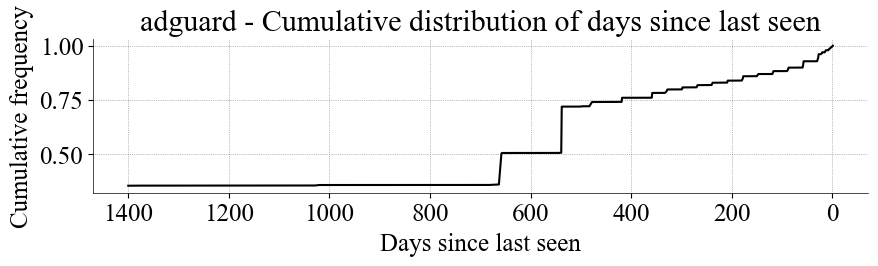

last_seen
 1400.0    45756
 1090.0        4
 1087.0       23
 1063.0        1
 1047.0     2785
           ...  
 3.0         143
 2.0          62
 1.0         203
 0.0         142
-1.0          66
Name: count, Length: 108, dtype: int64


/mnt/spring_scratch_pure/home/selhajj/filterlist-fingerprint/scripts/stats.py:734: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_title("Cumulative distribution of days since last seen")


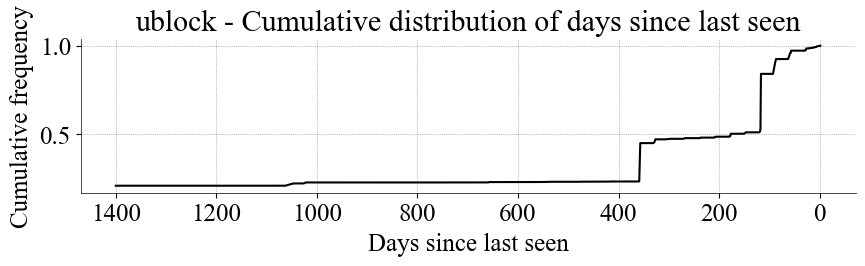

,non-removed count,mean,std,min,max,median,25%,75%,90%,>=88,>=365,>=357
adguard,97906 (35.37%),416.241503,231.855666,-1.0,1374.0,-538.0,-538.0,-208.0,-28.0,246456 (89.05%),210314 (75.99%),216470 (78.21%)
ublock,45644 (20.73%),207.814704,179.138357,-1.0,1400.0,-117.0,-357.0,-117.0,-87.0,201202 (91.38%),51024 (23.17%),98830 (44.88%)


''

In [79]:
reload(stats)

_, extra_data = stats.apply_to_datasets(lambda x: stats.rule_last_seen_statistics(*x, figsize=(10,2)), RULE_LAST_SEEN_DATASETS, is_notebook=True)
""

/tmp/ipykernel_407675/1715557738.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels( [int(i) for i in np.absolute(ax.get_xticks())])
/tmp/ipykernel_407675/1715557738.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels( [int(i) for i in np.absolute(ax.get_xticks())])


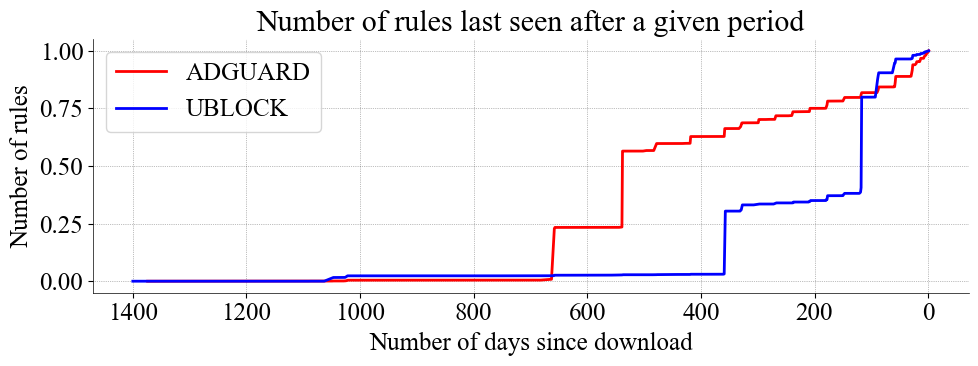

In [18]:
reload(stats)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

colors = ["r", "b"]

for i, (adblocker, (heights, x_labels)) in enumerate(zip(RULE_LAST_SEEN_DATASETS.keys(), extra_data)):
    
    # show the border of the bars
    # ax.bar( np.array(range( len(heights))) + i *0.4, heights, align='edge', width=0.4, label=adblocker.upper(), edgecolor='black', color=f"C{i}")
    
    ax.plot( x_labels, heights, label=adblocker.upper(), color=colors[i], linewidth=2)
    ax.set_xticklabels( [int(i) for i in np.absolute(ax.get_xticks())])
    
    # ax.set_xticks(range(len(heights)))
    # ax.set_xticklabels(x_labels, rotation=90)

ax.legend( loc="upper left")
ax.set_ylabel("Number of rules")
ax.set_xlabel("Number of days since download")

# change yticks to be 1k instead of 1000
# ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:1}".format(int(x/1000)) + "k" if x > 1000 else str(int(x))))


ax.set_title("Number of rules last seen after a given period")

# save figure
plt.tight_layout()
plt.savefig("figures/rules_last_seen.pdf", bbox_inches='tight')
plt.show()


## Breakdown by attack

last_seen
1400.0    21066
1049.0        1
1029.0        1
1025.0       34
1023.0       52
1022.0       20
665.0         1
663.0         3
658.0       953
657.0         5
541.0         6
538.0     14619
478.0       170
477.0         8
418.0       126
417.0         2
358.0        91
330.0        10
328.0        48
298.0        28
297.0         2
286.0         1
268.0        39
238.0        34
237.0         1
208.0        33
180.0         1
178.0        15
177.0        10
148.0        10
147.0        12
124.0         1
118.0        18
117.0        19
88.0         21
87.0         18
59.0          1
58.0         22
57.0         20
30.0          1
28.0         32
27.0         33
21.0          2
20.0          1
14.0          9
13.0          1
7.0           2
6.0           2
3.0           9
2.0           5
0.0           2
Name: count, dtype: int64


/mnt/spring_scratch_pure/home/selhajj/filterlist-fingerprint/scripts/stats.py:734: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_title("Cumulative distribution of days since last seen")


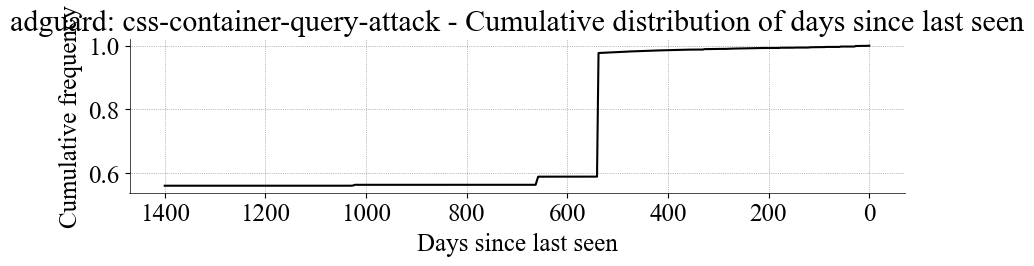

last_seen
 1400.0    55677
 1374.0      108
 1064.0        7
 1061.0        2
 1049.0       45
           ...  
 3.0         568
 2.0         206
 1.0         380
 0.0         398
-1.0         254
Name: count, Length: 92, dtype: int64


/mnt/spring_scratch_pure/home/selhajj/filterlist-fingerprint/scripts/stats.py:734: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_title("Cumulative distribution of days since last seen")


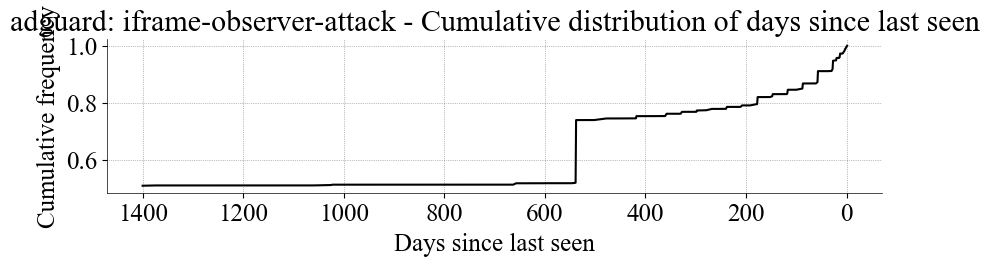

last_seen
 1400.0    20295
 1374.0        8
 1143.0       38
 1061.0       21
 1025.0       20
           ...  
 5.0          34
 3.0         385
 2.0           4
 1.0           2
-1.0         558
Name: count, Length: 78, dtype: int64


/mnt/spring_scratch_pure/home/selhajj/filterlist-fingerprint/scripts/stats.py:734: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_title("Cumulative distribution of days since last seen")


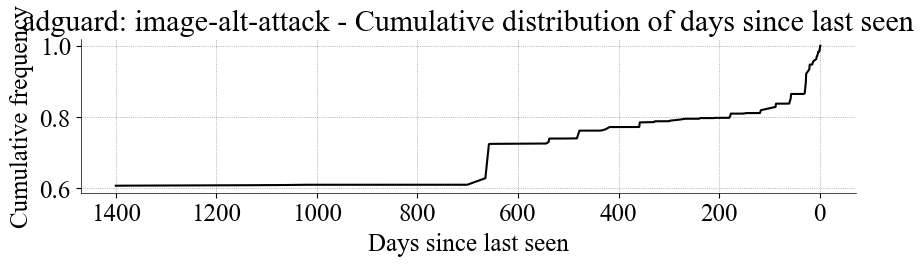

last_seen
 1400.0    50897
 1374.0        7
 1060.0        4
 1023.0       35
 1022.0       51
 682.0        52
 665.0       564
 658.0       123
 657.0       864
 547.0        33
 541.0         3
 539.0         3
 538.0     20107
 537.0         4
 507.0         2
 496.0       418
 478.0       364
 477.0        11
 419.0         4
 418.0       483
 417.0         2
 358.0       412
 357.0         2
 328.0       346
 298.0       235
 297.0        14
 268.0       328
 267.0         1
 238.0       519
 237.0         1
 208.0       263
 178.0       257
 177.0      2416
 148.0       123
 147.0       609
 118.0       118
 117.0      1165
 88.0        165
 87.0       1738
 58.0        179
 57.0       3936
 28.0        304
 27.0       2872
 21.0         48
 20.0        815
 14.0         83
 13.0       1199
 7.0          48
 6.0         152
 5.0         206
 4.0         295
 3.0         487
 2.0         141
 1.0         320
 0.0         305
-1.0         244
Name: count, dtype: int64


/mnt/spring_scratch_pure/home/selhajj/filterlist-fingerprint/scripts/stats.py:734: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_title("Cumulative distribution of days since last seen")


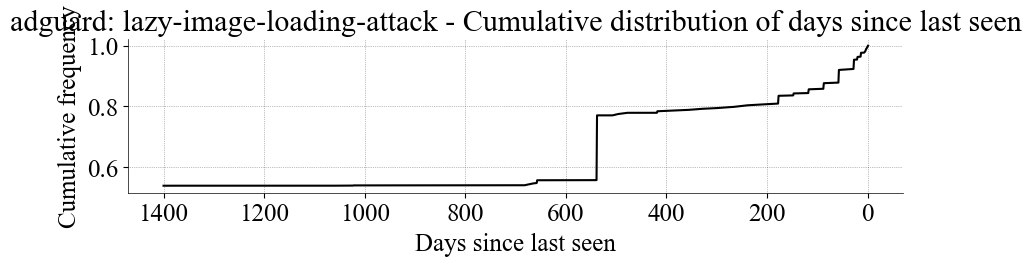

last_seen
1400.0    1404
1063.0       1
1047.0      76
1028.0       1
1022.0      39
663.0        4
658.0       36
539.0        2
537.0       10
477.0        8
419.0        1
418.0        1
417.0        3
359.0        9
357.0     1194
330.0        9
327.0       19
297.0        8
267.0        9
237.0        3
211.0        3
207.0        5
179.0        2
177.0        3
149.0       13
147.0       77
119.0        4
118.0        1
117.0       95
89.0         8
88.0       200
87.0        12
59.0         2
58.0         1
57.0        17
29.0         1
28.0         2
27.0         5
13.0        15
8.0          1
6.0          3
1.0          2
Name: count, dtype: int64


/mnt/spring_scratch_pure/home/selhajj/filterlist-fingerprint/scripts/stats.py:734: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_title("Cumulative distribution of days since last seen")


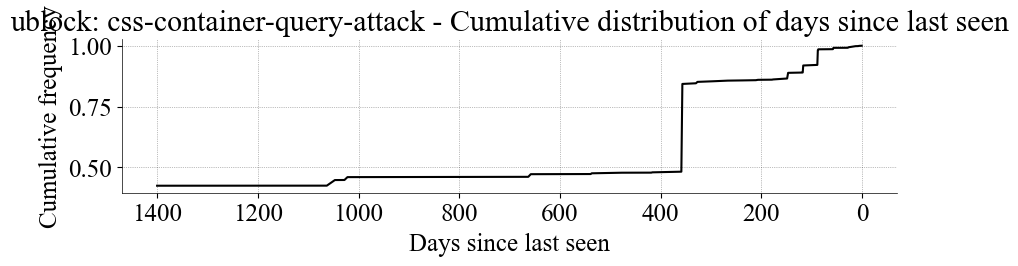

last_seen
 1400.0    33282
 1087.0        2
 1063.0        1
 1047.0        1
 1026.0        1
           ...  
 3.0          98
 2.0          45
 1.0         101
 0.0          58
-1.0          27
Name: count, Length: 61, dtype: int64


/mnt/spring_scratch_pure/home/selhajj/filterlist-fingerprint/scripts/stats.py:734: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_title("Cumulative distribution of days since last seen")


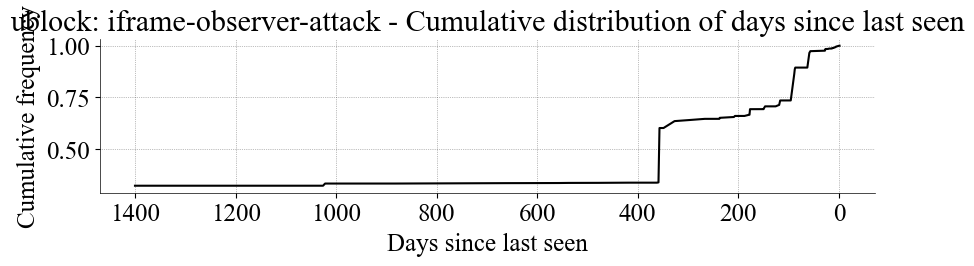

last_seen
1400.0    8441
1087.0       1
1026.0      46
1022.0       9
663.0       57
          ... 
5.0          5
4.0          4
2.0          2
1.0          2
0.0          5
Name: count, Length: 66, dtype: int64


/mnt/spring_scratch_pure/home/selhajj/filterlist-fingerprint/scripts/stats.py:734: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_title("Cumulative distribution of days since last seen")


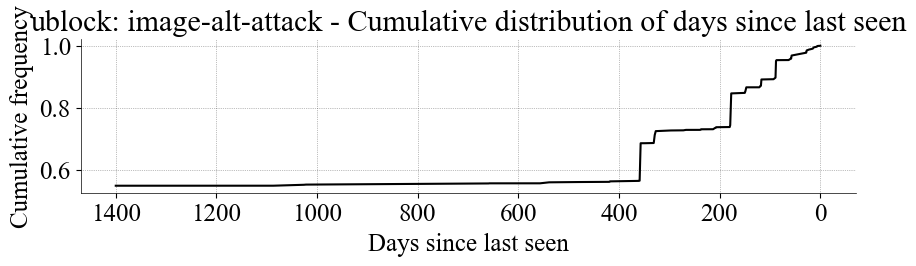

last_seen
1400.0    10914
1090.0        4
1087.0       22
1063.0        1
1047.0     2780
          ...  
4.0           6
3.0           1
2.0           2
1.0           2
0.0           5
Name: count, Length: 91, dtype: int64


/mnt/spring_scratch_pure/home/selhajj/filterlist-fingerprint/scripts/stats.py:734: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_title("Cumulative distribution of days since last seen")


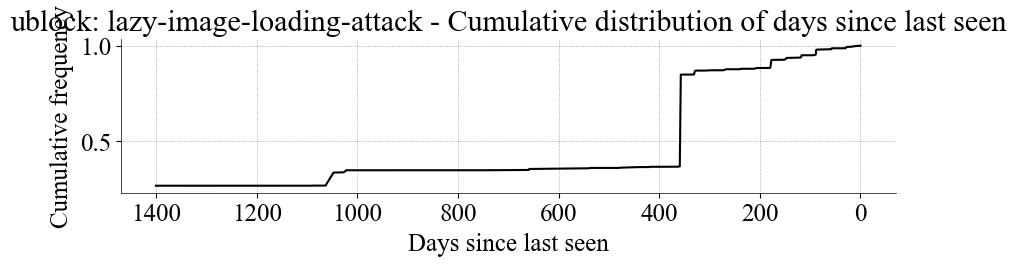

,non-removed count,mean,std,min,max,median,25%,75%,90%,>=88,>=365,>=357
adguard: css-container-query-attack,21066 (56.00%),535.017759,83.821591,0.0,1049.0,-538.0,-538.0,-538.0,-538.0,37461 (99.57%),37067 (98.53%),37158 (98.77%)
adguard: iframe-observer-attack,55677 (50.89%),321.745472,238.187887,-1.0,1374.0,-358.0,-538.0,-57.0,-20.0,92962 (84.98%),82402 (75.32%),83293 (76.14%)
adguard: image-alt-attack,20295 (60.77%),301.924145,286.025523,-1.0,1374.0,-177.0,-658.0,-27.0,-7.0,27671 (82.85%),25790 (77.22%),26221 (78.51%)
adguard: lazy-image-loading-attack,50897 (53.93%),332.419158,236.638101,-1.0,1374.0,-538.0,-538.0,-57.0,-27.0,81005 (85.83%),74031 (78.44%),74445 (78.88%)
ublock: css-container-query-attack,1404 (42.43%),342.698688,216.780231,1.0,1063.0,-357.0,-357.0,-267.0,-88.0,3248 (98.16%),1586 (47.93%),2789 (84.29%)
ublock: iframe-observer-attack,33170 (32.12%),230.759515,173.804473,-1.0,1400.0,-179.0,-357.0,-89.0,-59.0,91464 (88.57%),34807 (33.70%),62127 (60.16%)
ublock: image-alt-attack,8332 (54.05%),242.777464,205.263330,0.0,1400.0,-177.0,-357.0,-117.0,-59.0,14657 (95.09%),8658 (56.17%),10557 (68.49%)
ublock: lazy-image-loading-attack,10805 (26.49%),400.766821,254.478577,0.0,1400.0,-357.0,-357.0,-357.0,-153.0,39886 (97.80%),14954 (36.67%),34626 (84.91%)


''

In [81]:
reload(stats)
ATTACK_IMPORTANT_RULES = {
    adblocker + ": " + attack_name: pd.read_csv(DATA_DIR / f"fingerprinting/{adblocker}/{attack_name}/filterlist/summary/general_important_rules.csv")
    for adblocker in ["adguard", "ublock"]
    for attack_name in ATTACK_NAMES
    if Path(DATA_DIR / f"fingerprinting/{adblocker}/{attack_name}/filterlist/summary/general_important_rules.csv").exists()
}

RULE_LAST_SEEN_ATTACK_BREAKDOWN = {}

for adblocker_attack_name, important_rules in ATTACK_IMPORTANT_RULES.items():
    adblocker, attack_name = adblocker_attack_name.split(": ")
    download_timestamp, rules_last_seen = RULE_LAST_SEEN_DATASETS[adblocker]
    rules_last_seen = rules_last_seen[rules_last_seen["rule"].isin(important_rules["rule"])]
    RULE_LAST_SEEN_ATTACK_BREAKDOWN[adblocker_attack_name] = (download_timestamp, rules_last_seen)
    
_, extra_breakdown = stats.apply_to_datasets(lambda x: stats.rule_last_seen_statistics(*x, figsize=(10,2)), RULE_LAST_SEEN_ATTACK_BREAKDOWN, is_notebook=True)
""

/tmp/ipykernel_407675/220720313.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels( [int(i) for i in np.absolute(ax.get_xticks())])
/tmp/ipykernel_407675/220720313.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels( [int(i) for i in np.absolute(ax.get_xticks())])


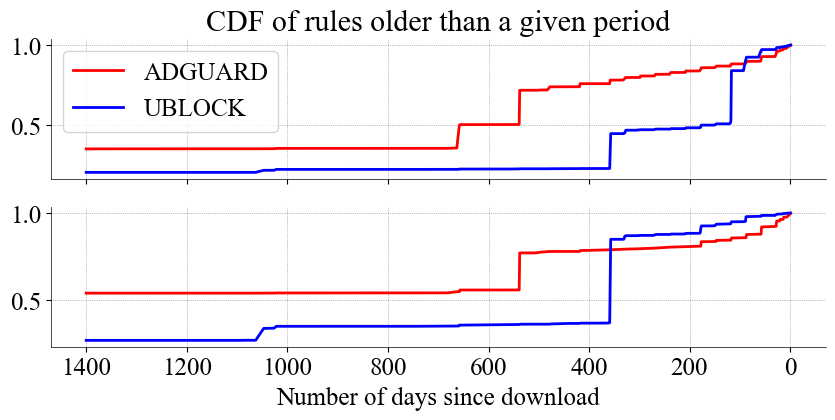

In [82]:
reload(stats)

# only for lazy-image-loading-attack
lazy_image_indeces = []
for i, name in enumerate(RULE_LAST_SEEN_ATTACK_BREAKDOWN.keys()):
    if "lazy-image-loading-attack" in name:
        lazy_image_indeces.append(i)


_extra_breakdowns = [extra_breakdown[i] for i in lazy_image_indeces]


fig, axes = plt.subplots(2, 1, figsize=(10, 4), sharex=True)

ax = axes[0]
ax2 = axes[1]

ax.set_title("CDF of rules older than a given period")


def plot(ax, extra_data):
    for i, (adblocker, (heights, x_labels)) in enumerate(zip(RULE_LAST_SEEN_DATASETS.keys(), extra_data)):
        
        # show the border of the bars
        # ax.bar( np.array(range( len(heights))) + i *0.4, heights, align='edge', width=0.4, label=adblocker.upper(), edgecolor='black', color=f"C{i}")
        
        # ax.set_xticks(range(len(heights)))
        # ax.set_xticklabels(x_labels, rotation=90)
        
        ax.plot(x_labels, heights, label=adblocker.upper(), color=colors[i], linewidth=2)
    
    ax.set_xticklabels( [int(i) for i in np.absolute(ax.get_xticks())])

    # ax.set_ylabel("Number of rules")
    # ax.set_ylabel("Cumulative number of rules")
    
    # change yticks to be 1k instead of 1000
    # ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:1}".format(int(x/1000)) + "k" if x > 1000 else str(int(x))))
    
plot(ax, extra_data)
plot(ax2, _extra_breakdowns)
# save figure
# plt.tight_layout()

ax.legend( loc="upper left")
ax2.set_xlabel("Number of days since download")


plt.savefig("figures/rules_last_seen.pdf", bbox_inches='tight')
plt.show()

# Equivalence Set Stability

last_seen
1400.0    72
658.0      1
541.0      1
Name: count, dtype: int64


/mnt/spring_scratch_pure/home/selhajj/filterlist-fingerprint/scripts/stats.py:811: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  return stats, {"equivalent_set_last_seen_histogram": (fig, ax)}, ((counts.cumsum() / counts.sum()).values, -counts.index)


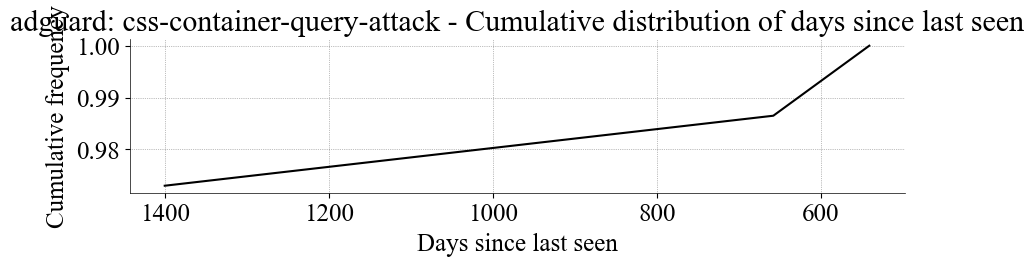

last_seen
1400.0    85
1022.0     1
541.0      1
Name: count, dtype: int64


/mnt/spring_scratch_pure/home/selhajj/filterlist-fingerprint/scripts/stats.py:811: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  return stats, {"equivalent_set_last_seen_histogram": (fig, ax)}, ((counts.cumsum() / counts.sum()).values, -counts.index)


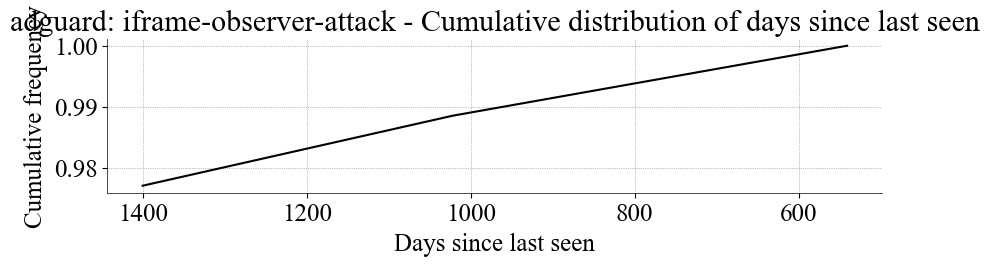

last_seen
1400.0    77
701.0      1
658.0      1
541.0      1
237.0      1
Name: count, dtype: int64


/mnt/spring_scratch_pure/home/selhajj/filterlist-fingerprint/scripts/stats.py:811: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  return stats, {"equivalent_set_last_seen_histogram": (fig, ax)}, ((counts.cumsum() / counts.sum()).values, -counts.index)


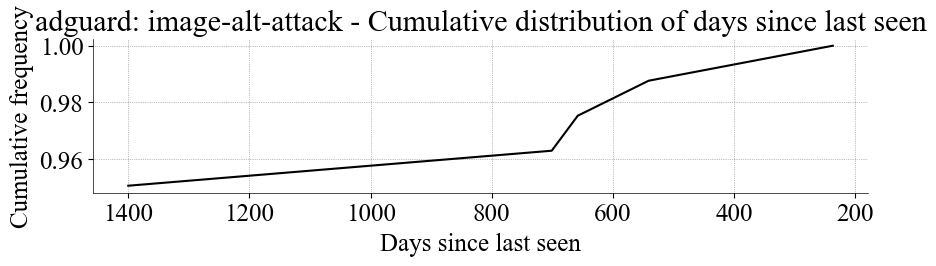

last_seen
1400.0    86
237.0      1
Name: count, dtype: int64


/mnt/spring_scratch_pure/home/selhajj/filterlist-fingerprint/scripts/stats.py:811: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  return stats, {"equivalent_set_last_seen_histogram": (fig, ax)}, ((counts.cumsum() / counts.sum()).values, -counts.index)


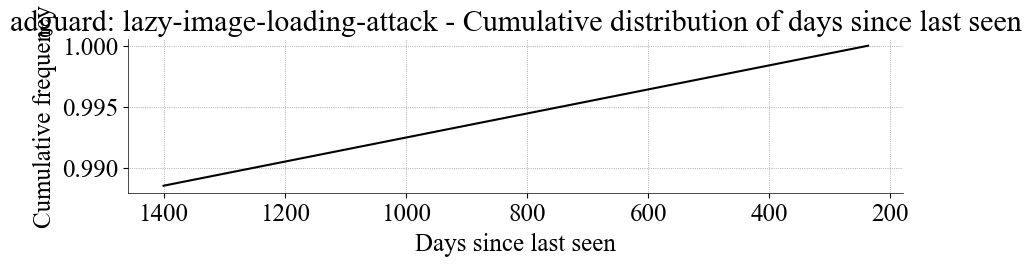

last_seen
1400.0    44
1047.0     1
1022.0     1
663.0      1
537.0      1
357.0      5
327.0      1
Name: count, dtype: int64


/mnt/spring_scratch_pure/home/selhajj/filterlist-fingerprint/scripts/stats.py:811: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  return stats, {"equivalent_set_last_seen_histogram": (fig, ax)}, ((counts.cumsum() / counts.sum()).values, -counts.index)


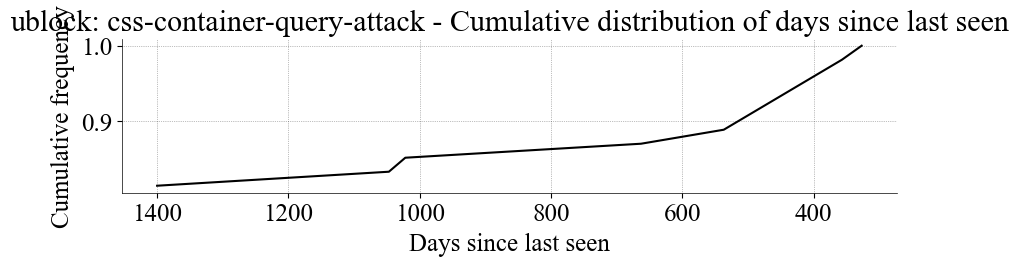

last_seen
1400.0    51
362.0      1
357.0      5
327.0      1
177.0      1
Name: count, dtype: int64


/mnt/spring_scratch_pure/home/selhajj/filterlist-fingerprint/scripts/stats.py:811: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  return stats, {"equivalent_set_last_seen_histogram": (fig, ax)}, ((counts.cumsum() / counts.sum()).values, -counts.index)


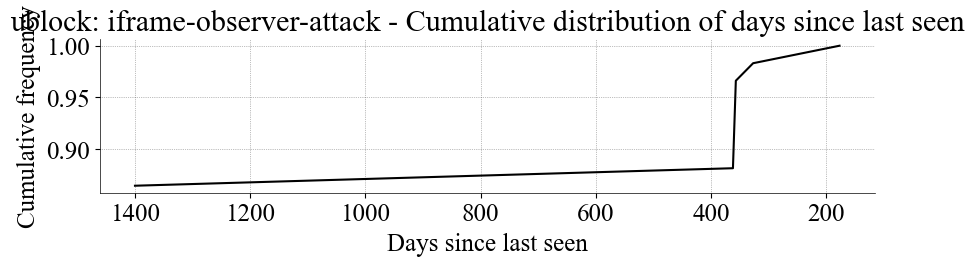

last_seen
1400.0    53
1022.0     1
357.0      4
327.0      2
117.0      1
0.0        1
Name: count, dtype: int64


/mnt/spring_scratch_pure/home/selhajj/filterlist-fingerprint/scripts/stats.py:811: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  return stats, {"equivalent_set_last_seen_histogram": (fig, ax)}, ((counts.cumsum() / counts.sum()).values, -counts.index)


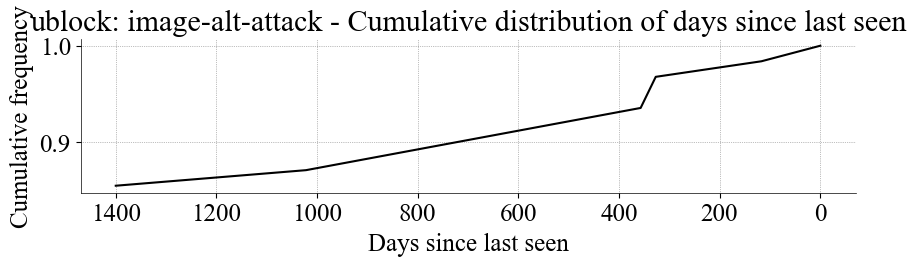

last_seen
1400.0    58
1022.0     1
357.0      2
0.0        1
Name: count, dtype: int64


/mnt/spring_scratch_pure/home/selhajj/filterlist-fingerprint/scripts/stats.py:811: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  return stats, {"equivalent_set_last_seen_histogram": (fig, ax)}, ((counts.cumsum() / counts.sum()).values, -counts.index)


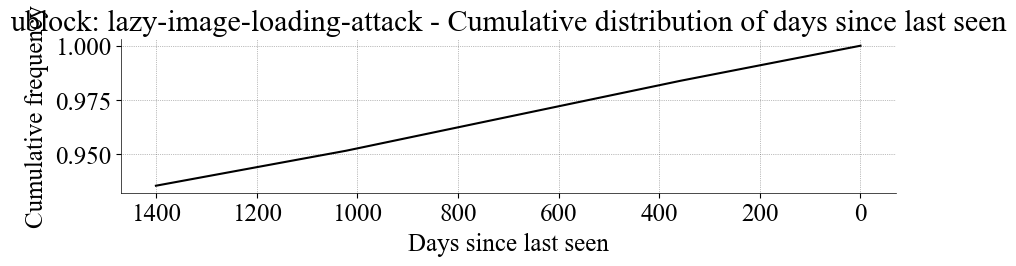

,mean,std,min,max,median,10%,25%,75%,90%,non-removed count
adguard: css-container-query-attack,599.500000,82.731493,541.0,658.0,599.5,552.7,570.25,628.75,646.3,72 (97.30%)
adguard: iframe-observer-attack,781.500000,340.118362,541.0,1022.0,781.5,589.1,661.25,901.75,973.9,85 (97.70%)
adguard: image-alt-attack,534.250000,209.382226,237.0,701.0,599.5,328.2,465.00,668.75,688.1,77 (95.06%)
adguard: lazy-image-loading-attack,237.000000,NaN,237.0,237.0,237.0,237.0,237.00,237.00,237.0,86 (98.85%)
ublock: css-container-query-attack,538.100000,282.309700,327.0,1047.0,357.0,354.0,357.00,631.50,1024.5,44 (81.48%)
ublock: iframe-observer-attack,450.111111,361.100209,177.0,1400.0,357.0,297.0,357.00,357.00,569.6,50 (84.75%)
ublock: image-alt-attack,462.100000,422.487725,0.0,1400.0,357.0,105.3,327.00,357.00,1059.8,52 (83.87%)
ublock: lazy-image-loading-attack,434.000000,426.598172,0.0,1022.0,357.0,107.1,267.75,523.25,822.5,58 (93.55%)


''

In [74]:
reload(stats)

ATTACK_EQUIVALENT_SET_AND_RULES = {}

for adblocker_and_attack_name, important_rules in ATTACK_IMPORTANT_RULES.items():
    adblocker, attack_name = adblocker_and_attack_name.split(": ")
    equivalent_set_rules = ATTACK_IMPORTANT_RULES[adblocker_and_attack_name]
    download_timestamp, rule_last_seen = RULE_LAST_SEEN_DATASETS[adblocker]
    
    ATTACK_EQUIVALENT_SET_AND_RULES[adblocker_and_attack_name] = (download_timestamp, equivalent_set_rules, rule_last_seen)
    
_, extra = stats.apply_to_datasets(lambda x: stats.equivalent_set_max_last_seen_statistics(*x, figsize=(10,2)), ATTACK_EQUIVALENT_SET_AND_RULES, is_notebook=True)
""

/tmp/ipykernel_407675/220720313.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels( [int(i) for i in np.absolute(ax.get_xticks())])
/tmp/ipykernel_407675/220720313.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels( [int(i) for i in np.absolute(ax.get_xticks())])
/tmp/ipykernel_407675/441383592.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels( [int(i) for i in np.absolute(ax.get_xticks())])


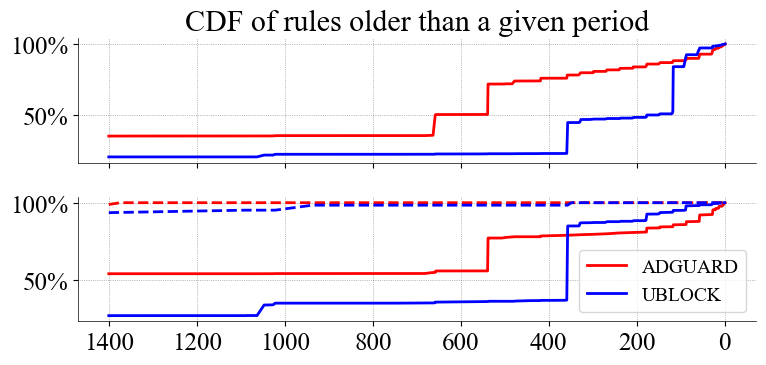

In [97]:
lazy_image_indeces = []
for i, name in enumerate(ATTACK_EQUIVALENT_SET_AND_RULES.keys()):
    if "lazy-image-loading-attack" in name:
        lazy_image_indeces.append(i)


_extra_sets = [extra[i] for i in lazy_image_indeces]

def plot_interpolated(ax, extra_sets, extra_rules):
    
    def interpolate(x, y, x_new):
        y_new = []
        i = 0
        yi = 0
        
        for xj in x_new:
            
            if i == len(x):
                yi = 1
                y_new.append(yi)
                continue
            
            if xj < x[i]:
                y_new.append(yi)
            else:
                while i < len(x) and xj > x[i]:
                    i += 1
                    
                if i == len(x):
                    yi = 1
                else:
                    yi = y[i]
                    
                y_new.append(yi)
                
        return y_new
    
    for i, (adblocker, (height_sets, x_labels_sets), (height_rules, x_labels_rules)) in enumerate(zip(RULE_LAST_SEEN_DATASETS.keys(), extra_sets, extra_rules)):
        
        y_new = interpolate(x_labels_sets, height_sets, x_labels_rules)
        
        ax.plot(x_labels_rules, y_new, color=colors[i], linestyle="--", linewidth=2)
    
    ax.set_xticklabels( [int(i) for i in np.absolute(ax.get_xticks())])

fig, axes = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
ax = axes[0]
ax2 = axes[1]

ax.set_title("CDF of rules older than a given period")

plot(ax, extra_data)
plot(ax2, _extra_breakdowns)
plot_interpolated(ax2, _extra_sets, _extra_breakdowns)

# make font size smaller for legend
ax2.legend( loc="lower right", fontsize=14)

# make y axis percentage
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.0%}".format(x)))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.0%}".format(x)))

fig.tight_layout()
plt.savefig("figures/rules_and_set_last_seen.pdf", bbox_inches='tight')